Replaced resnet50 by resnext101_32x8d  
prev model: model_16

In [1]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

from hack_utils import ScaleMinSideToSize, CropCenter, RandomHorizontalFlip, TransformByKeys
from hack_utils import ThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission
from hack_utils import stqdm
from hack_train import predict

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../data/'
LOCAL_DATA_DIR = '/work/local_data/made_cv/contest1'

In [3]:
GPUs = [0, 1, 2]

In [4]:
NUM_PTS = 971
CROP_SIZE = 128
BATCH_SIZE = 100 * len(GPUs)
LR = 5e-4
NUM_WORKERS = 24
MODEL_NAME = 'model_18'

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in stqdm(loader, total=len(loader), desc="training...", leave=True):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

In [7]:
def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in stqdm(loader, total=len(loader), desc="validation...", leave=True):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)

In [8]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
#     RandomHorizontalFlip(0.5),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.4782, 0.3758, 0.3277], std=[0.3077, 0.2652, 0.2521]), ("image",)),
    TransformByKeys(transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3)), ("image",)),
])

In [9]:
test_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.4782, 0.3758, 0.3277], std=[0.3077, 0.2652, 0.2521]), ("image",)),
])

In [10]:
train_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="train")
val_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), test_transforms, split="val")

Total lines (without header): 393930
Loading train dataset (315144 lines)



Total lines (without header): 393930
Loading val dataset (78786 lines)


In [11]:
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                   shuffle=True, drop_last=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                 shuffle=False, drop_last=False)

In [10]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [11]:
model = models.resnext101_32x8d(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)

model = nn.DataParallel(model, device_ids=GPUs)

model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [12]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)
loss_fn = fnn.mse_loss

In [15]:
N_EPOCHS = 100
best_val_loss = np.inf
for epoch in stqdm(range(N_EPOCHS), total=N_EPOCHS, desc="Epoch"):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    lr_scheduler.step(val_loss)
    print("Epoch #{:2}:\ttrain loss: {:.5f}\tval loss: {:.5f}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)

Epoch # 0:	train loss: 154.48544	val loss: 5.82686


Epoch # 1:	train loss: 5.07668	val loss: 3.98812


Epoch # 2:	train loss: 3.75658	val loss: 2.84561


Epoch # 3:	train loss: 3.05609	val loss: 2.42662


Epoch # 4:	train loss: 2.77926	val loss: 2.44180


Epoch # 5:	train loss: 2.55562	val loss: 2.26685


Epoch # 6:	train loss: 2.37507	val loss: 2.07043


Epoch # 7:	train loss: 2.29695	val loss: 2.18684


Epoch # 8:	train loss: 2.24954	val loss: 2.01294


Epoch # 9:	train loss: 2.10100	val loss: 1.88021


Epoch #10:	train loss: 1.97089	val loss: 1.91990


Epoch #11:	train loss: 1.89215	val loss: 1.88347


Epoch #12:	train loss: 1.70437	val loss: 1.73804


Epoch #13:	train loss: 1.62712	val loss: 1.79983


Epoch #14:	train loss: 1.56831	val loss: 1.75932


Epoch #15:	train loss: 1.47363	val loss: 1.71072


Epoch #16:	train loss: 1.42240	val loss: 1.69314


Epoch #17:	train loss: 1.38813	val loss: 1.67917


Epoch #18:	train loss: 1.35586	val loss: 1.68855


Epoch #19:	train loss: 1.34223	val loss: 1.68545


Epoch #20:	train loss: 1.28706	val loss: 1.67093


Epoch #21:	train loss: 1.25927	val loss: 1.66905


Epoch #22:	train loss: 1.24437	val loss: 1.66567


Epoch #23:	train loss: 1.22573	val loss: 1.65953


Epoch #24:	train loss: 1.21121	val loss: 1.67156


Epoch #25:	train loss: 1.19994	val loss: 1.66587


Epoch #26:	train loss: 1.17153	val loss: 1.65609


Epoch #27:	train loss: 1.16074	val loss: 1.65466


Epoch #28:	train loss: 1.15092	val loss: 1.65529


Epoch #29:	train loss: 1.14023	val loss: 1.65932


Epoch #30:	train loss: 1.12776	val loss: 1.65350


Epoch #31:	train loss: 1.12457	val loss: 1.65810


Epoch #32:	train loss: 1.11904	val loss: 1.65398


Epoch #33:	train loss: 1.11204	val loss: 1.65560


Epoch #34:	train loss: 1.10586	val loss: 1.65350


Epoch #35:	train loss: 1.10471	val loss: 1.65566


Epoch #36:	train loss: 1.10544	val loss: 1.65659


Epoch #37:	train loss: 1.09920	val loss: 1.65507


Epoch #38:	train loss: 1.09971	val loss: 1.65279


Epoch #39:	train loss: 1.09912	val loss: 1.65274


Epoch #40:	train loss: 1.10087	val loss: 1.65154


Epoch #41:	train loss: 1.09763	val loss: 1.65201


KeyboardInterrupt: 

In [16]:
f'Best validation loss: {best_val_loss}'

'Best validation loss: 1.6515383212738617'

In [21]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1.953125e-06
    weight_decay: 0.01
)

In [24]:
lr_scheduler.state_dict()

{'factor': 0.5,
 'min_lrs': [0],
 'patience': 1,
 'verbose': False,
 'cooldown': 0,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 0.0001,
 'threshold_mode': 'rel',
 'best': 1.6515383212738617,
 'num_bad_epochs': 1,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': 42,
 '_last_lr': [1.953125e-06]}

In [13]:
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [14]:
test_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'test'), test_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                  shuffle=False, drop_last=False)

Total lines (without header): 99819


In [15]:
test_predictions = predict(model, test_dataloader, device)
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl"), "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                 "landmarks": test_predictions}, fp)

In [18]:
create_submission(DATA_DIR, test_predictions,
                 os.path.join(DATA_DIR, f"{MODEL_NAME}_submit_val_loss_{best_val_loss:.5f}.csv"))

In [19]:
TEST_PREDICTIONS_FILENAME = os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl")
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [20]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [21]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


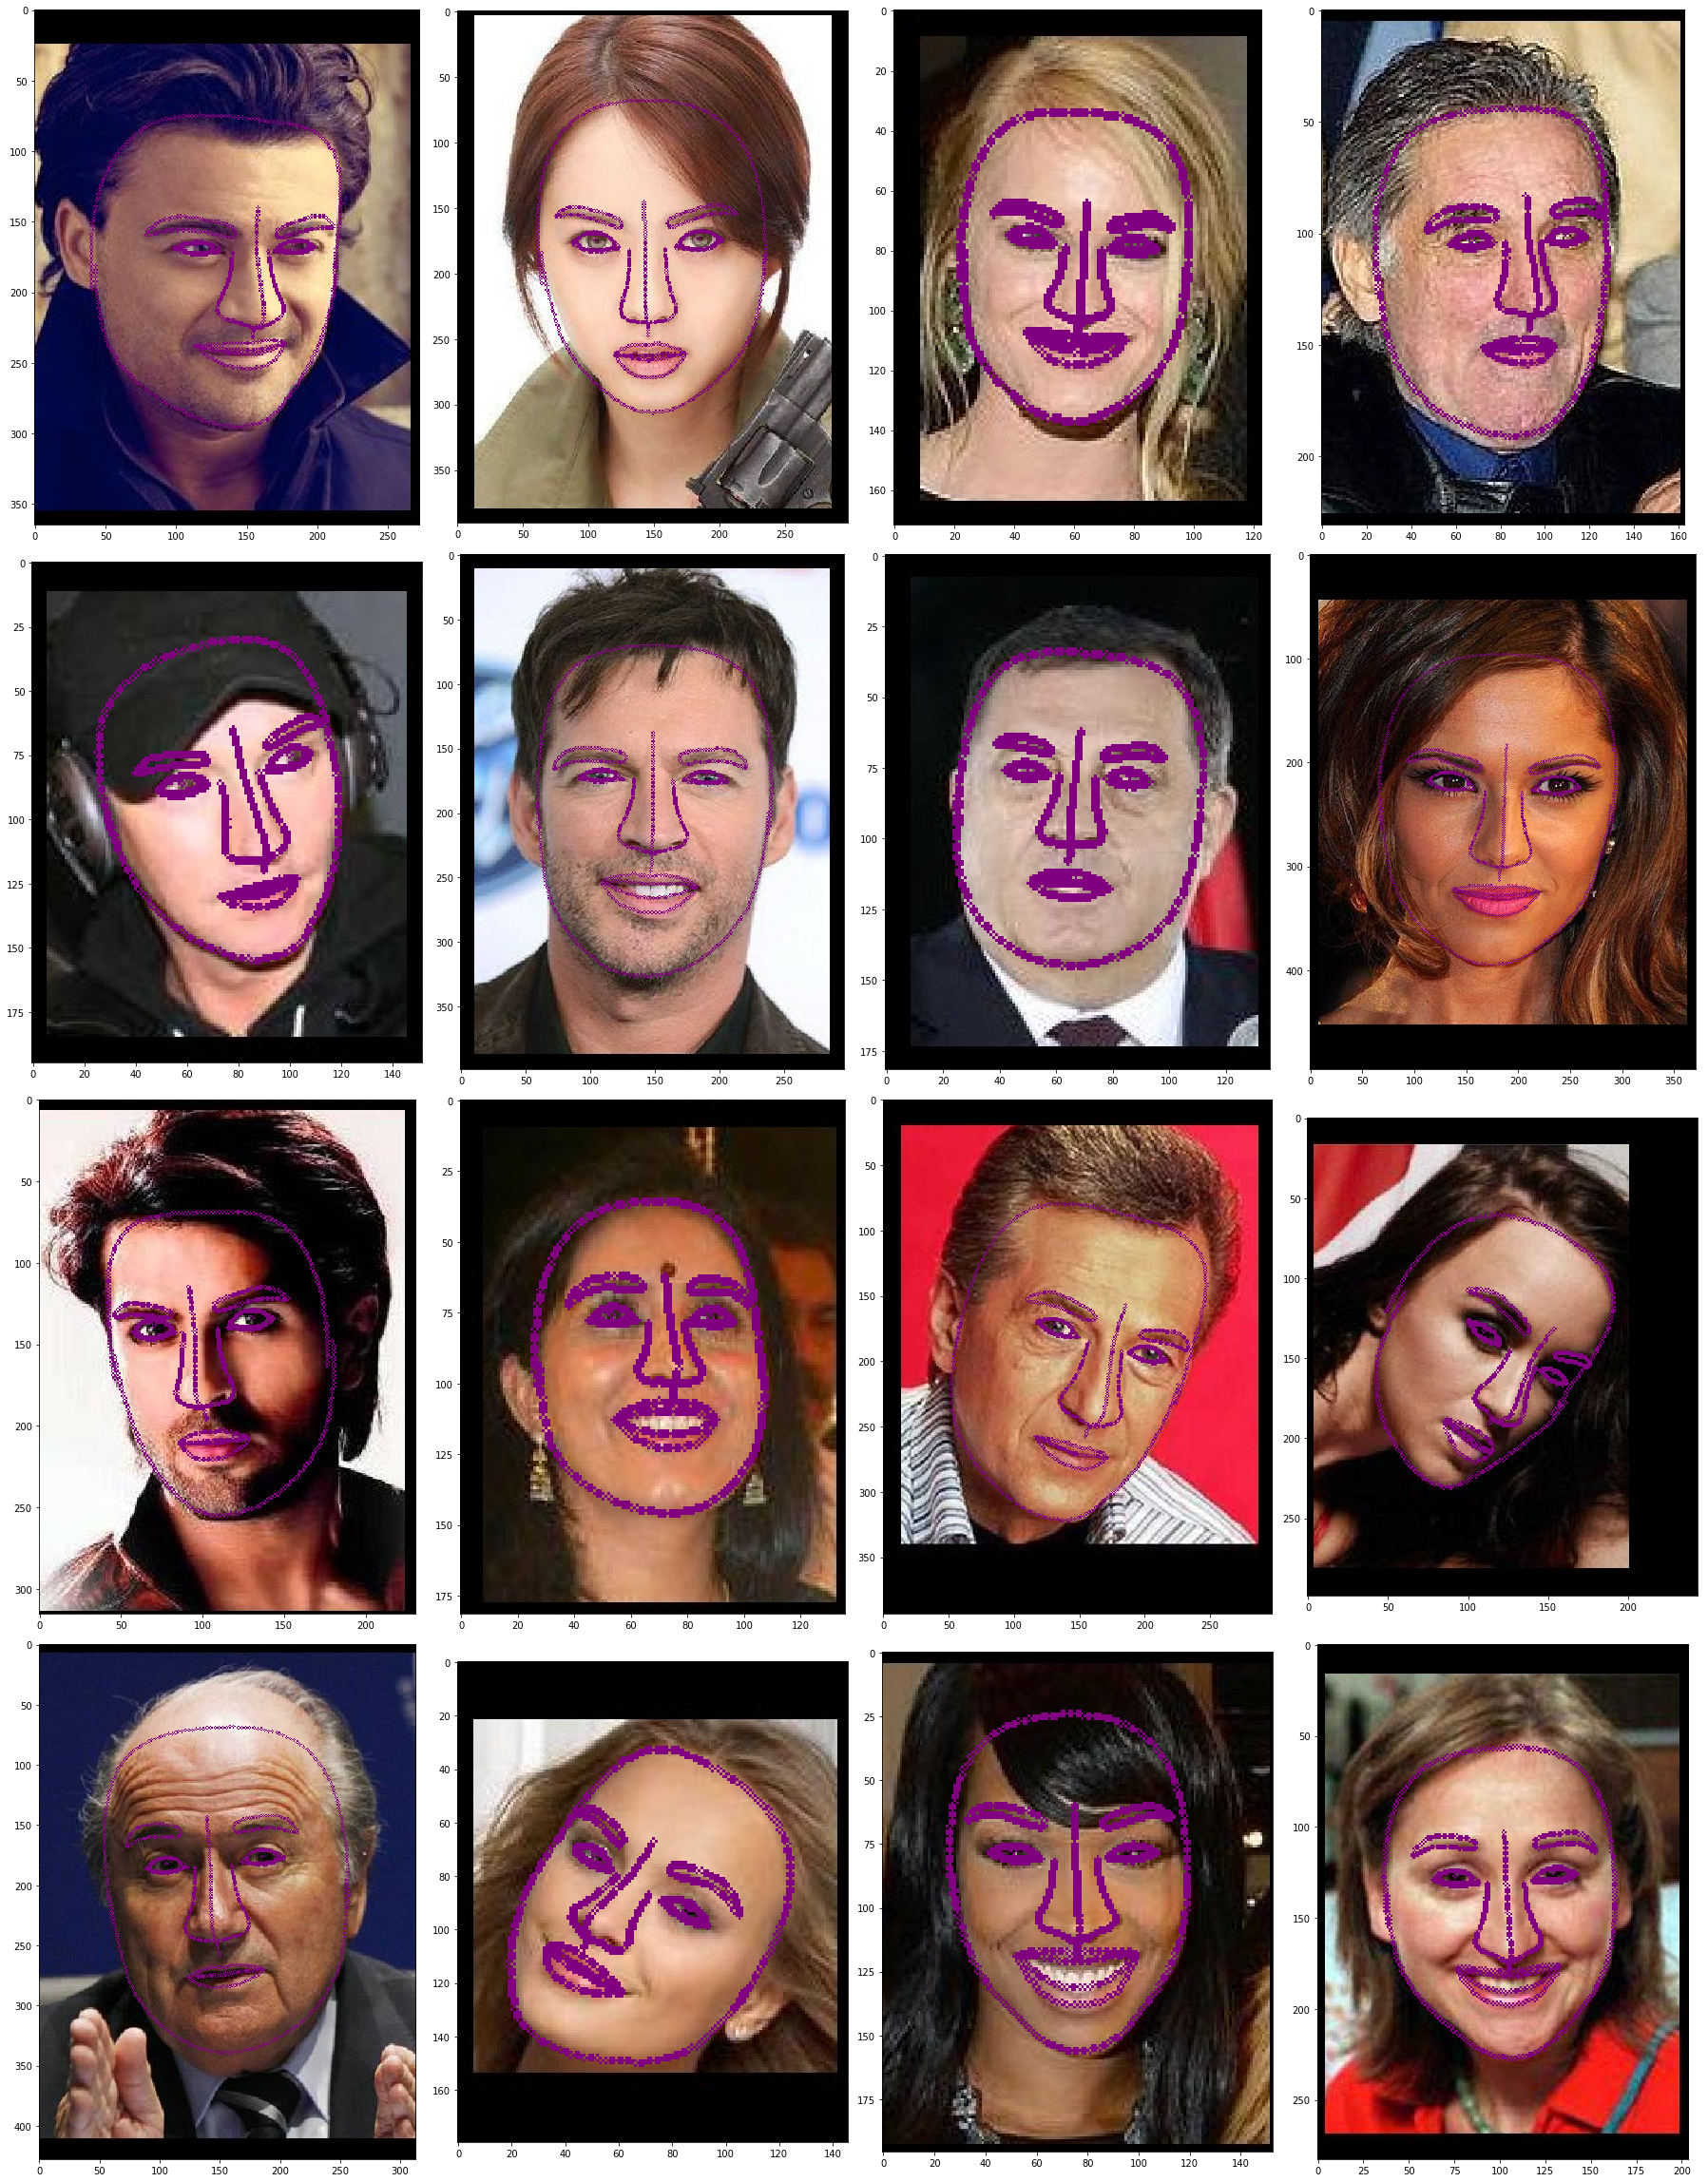

In [22]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()